In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [ ]:
df = pd.read_csv('/content/chatgpt_tweets-4.csv', engine='python')
df.head()


,date,tweet_text
0,2022-01-27 14:42:36+00:00,RT GPT-3-like models with extended training co...
1,2022-01-08 08:46:33+00:00,RT Testing GPT-3 on Elementary Physics Unveils...
2,2022-01-08 08:37:45+00:00,Testing GPT-3 on Elementary Physics Unveils So...
3,2021-11-26 16:49:24+00:00,Now we know how @BorisJohnson wrote his speech...
4,2021-11-26 15:07:12+00:00,@sharplm shares how GPT-3 generates believable...


In [ ]:
df.shape

(100026, 2)

## EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100026 entries, 0 to 100025
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   date        100026 non-null  object
 1   tweet_text  100026 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [ ]:
df.isnull().sum()

date          0
tweet_text    0
dtype: int64

In [ ]:
# Removing URL Mentioned in the tweet 
df['tweet_text'] = df['tweet_text'].str.replace(r'http\S+|www.\S+|@\S+', '', case=False)


In [ ]:
# Remove any non-alphanumeric characters from the text:
df['tweet_text'] = df['tweet_text'].str.replace(r'[^a-zA-Z0-9\s]', '')


In [ ]:
#Converting text to lowercase
df['tweet_text'] = df['tweet_text'].str.lower()


In [ ]:
#Word frequency analysis:
from collections import Counter

# Drop any rows with missing values
df.dropna(subset=['tweet_text'], inplace=True)

words = Counter()
df['tweet_text'].str.split().apply(words.update)
print(words.most_common(20))



[('gpt3', 95397), ('to', 65413), ('education', 63366), ('the', 60088), ('ai', 57448), ('and', 42080), ('a', 38614), ('with', 38341), ('in', 35728), ('of', 34069), ('edtech', 31073), ('how', 30522), ('coding', 29587), ('is', 28887), ('you', 27498), ('can', 26479), ('chatgpt', 25713), ('for', 21544), ('on', 21526), ('this', 21478)]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


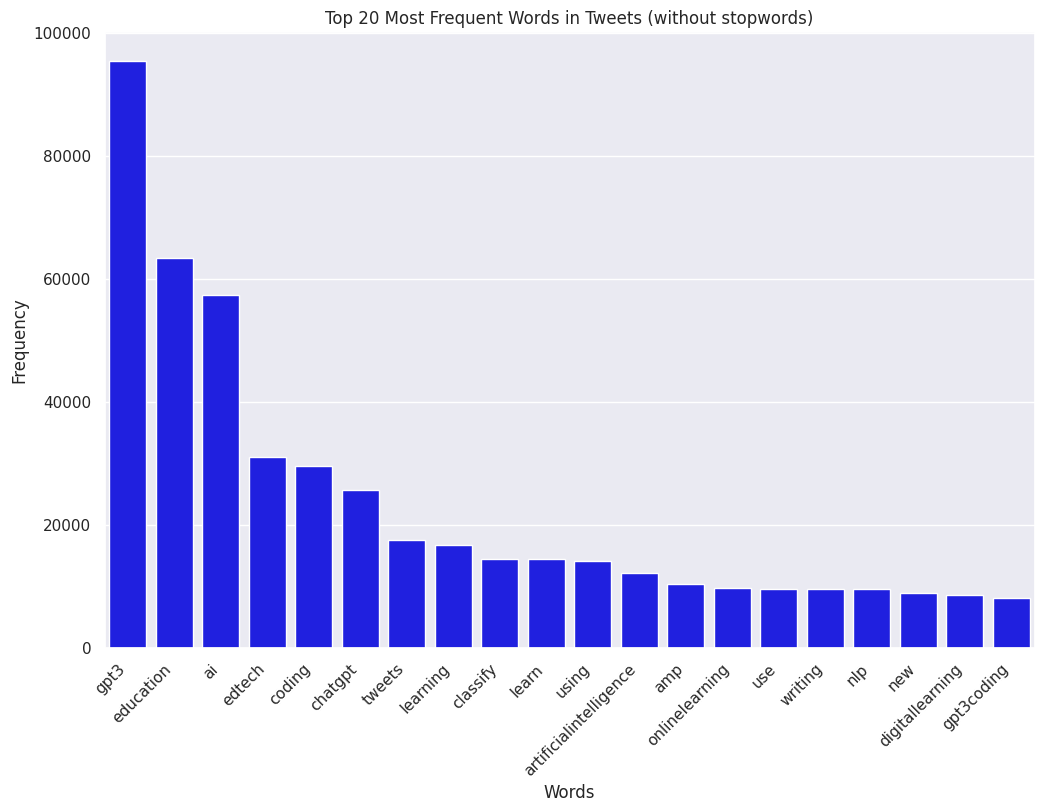

In [ ]:
import seaborn as sns
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')


# Remove stopwords
stop_words = set(stopwords.words('english'))
df['tweet_text'] = df['tweet_text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

words = Counter()
df['tweet_text'].str.split().apply(words.update)

# Get the top 20 most frequent words
top_words = dict(words.most_common(20))

# Create a bar chart
sns.set(style='darkgrid')
plt.figure(figsize=(12, 8))
sns.barplot(x=list(top_words.keys()), y=list(top_words.values()), color='blue')
plt.title('Top 20 Most Frequent Words in Tweets (without stopwords)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


## Performing sentiment analysis 

In [ ]:
from textblob import TextBlob


# Define a function to get the sentiment polarity of a tweet
def get_tweet_sentiment(tweet):
    # Create a TextBlob object from the tweet text
    blob = TextBlob(tweet)
    # Get the sentiment polarity of the TextBlob object
    sentiment = blob.sentiment.polarity
    # Return the sentiment polarity value
    return sentiment

# Apply the get_tweet_sentiment function to each tweet in the dataframe
df['sentiment'] = df['tweet_text'].apply(get_tweet_sentiment)

# Print the first 10 rows of the dataframe with the sentiment polarity values
print(df[['tweet_text', 'sentiment']].head(10))


                                          tweet_text  sentiment
0  rt gpt3like models extended training could fut...   0.000000
1  rt testing gpt3 elementary physics unveils imp...   0.350000
2  testing gpt3 elementary physics unveils import...   0.350000
3             know wrote speech gpt3 piorflan edtech   0.000000
4  shares gpt3 generates believable text via tran...   0.000000
5  artificialintelligence getting better writing ...   0.500000
6  classifying tweets gpt3 easy use tool categori...   0.433333
7  rt gpt3like models extended training could fut...   0.000000
8  rt testing gpt3 elementary physics unveils imp...   0.350000
9  testing gpt3 elementary physics unveils import...   0.350000


Here if the sentiment is near 0 it represents negativity and vice versa

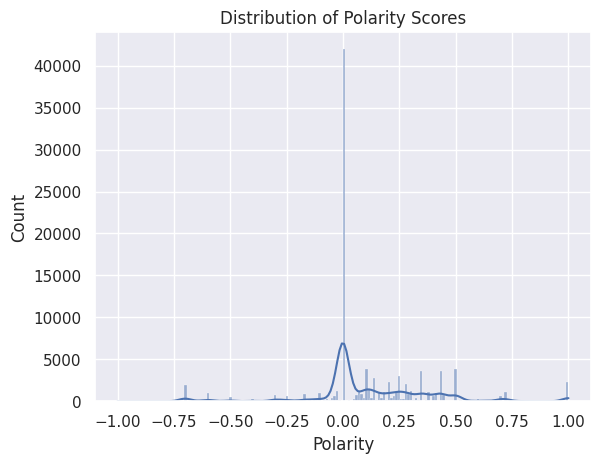

In [ ]:
sns.histplot(data=df, x='sentiment', kde=True)
plt.title('Distribution of Polarity Scores')
plt.xlabel('Polarity')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Plot a histogram of the sentiment polarity values
plt.hist(df['sentiment'], bins=20)
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Polarity')
plt.show()


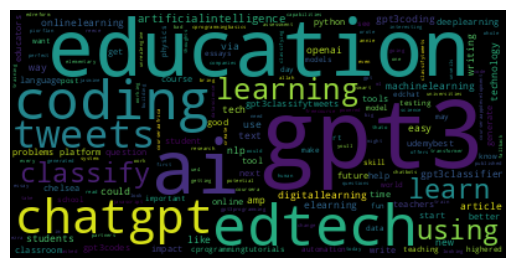

In [ ]:
# Creating a wordcloud
from wordcloud import WordCloud

# Get list of words
words = df['tweet_text'].str.split(expand=True).stack().tolist()

# Count frequency of each word
word_freq = Counter(words)

# Generate wordcloud with unique words
unique_words = set(words)
wordcloud = WordCloud().generate_from_frequencies({word: freq for word, freq in word_freq.items() if word in unique_words})

# Display the wordcloud
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



## Applying unsupervised learning 

In [ ]:
df = pd.read_csv('/content/chatgpt_tweets-4.csv')

In [ ]:
! pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

In [ ]:
# Preprocess the text data
def preprocess(text):
    return [token for token in simple_preprocess(text) if token not in gensim.parsing.preprocessing.STOPWORDS]

df['processed_text'] = df['tweet_text'].apply(preprocess)

# Create a dictionary of the processed text data
dictionary = Dictionary(df['processed_text'])

# Create a bag of words corpus
corpus = [dictionary.doc2bow(text) for text in df['processed_text']]

# Train an LDA model on the corpus
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=5,
                     passes=10,
                     random_state=42)

# Print the topics and the top 10 words in each topic
for topic, words in lda_model.print_topics(num_words=10):
    print(f'Topic {topic}: {words}')

Topic 0: 0.063*"gpt" + 0.046*"ai" + 0.045*"https" + 0.026*"education" + 0.026*"edtech" + 0.018*"openai" + 0.012*"coding" + 0.010*"machinelearning" + 0.008*"learn" + 0.007*"python"
Topic 1: 0.043*"chatgpt" + 0.037*"ai" + 0.034*"education" + 0.028*"https" + 0.025*"gpt" + 0.022*"edtech" + 0.021*"world" + 0.016*"true" + 0.016*"false" + 0.015*"new"
Topic 2: 0.102*"gpt" + 0.037*"coding" + 0.030*"education" + 0.027*"tweets" + 0.021*"classify" + 0.017*"learn" + 0.015*"learning" + 0.015*"https" + 0.013*"ai" + 0.012*"easy"
Topic 3: 0.057*"chatgpt" + 0.057*"ai" + 0.050*"https" + 0.036*"education" + 0.033*"edtech" + 0.023*"gpt" + 0.013*"writing" + 0.010*"article" + 0.010*"nlp" + 0.009*"openai"
Topic 4: 0.083*"gpt" + 0.052*"https" + 0.043*"education" + 0.027*"coding" + 0.016*"ai" + 0.015*"edtech" + 0.011*"learning" + 0.011*"onlinelearning" + 0.011*"nlp" + 0.008*"technology"


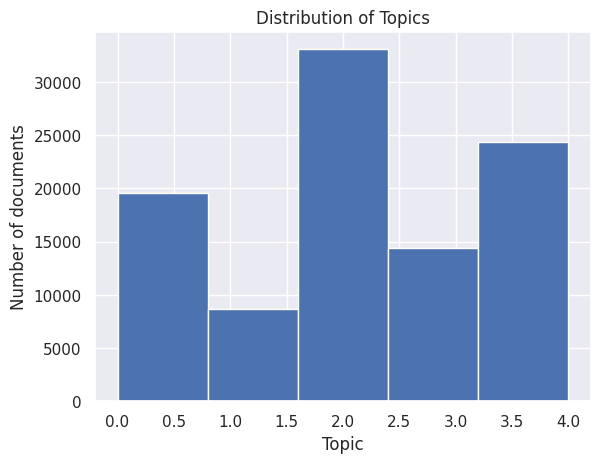

In [ ]:
# Get the distribution of topics in the corpus
topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]

# Create a list of the dominant topic for each document
dominant_topics = [max(topics, key=lambda x: x[1])[0] for topics in topic_distribution]

# Plot the histogram
plt.hist(dominant_topics, bins=lda_model.num_topics)
plt.xlabel('Topic')
plt.ylabel('Number of documents')
plt.title('Distribution of Topics')
plt.show()


In [ ]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()


vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.display(vis)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Applying VADER (Valence Aware Dictionary and Sentiment Reasoner)

VADER is a lexcion and rule-based sentiment analysis tool that is designed to analyze social media data. It uses a sentiment lexicon that includes both postive and negative sentiment words, as well as words that are often used to express sentiment in social media texts such as lol, omg. It assigns each word in a given text a sentiment score based on its presence in the sentiment lexicon and its context within the text. It then calculates an overall sentiment score for the text based on the sentiment scores of the individual words.

In [ ]:
import nltk
nltk.download('vader_lexicon')


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# Preprocess the data
vectorizer = TfidfVectorizer(stop_words='english')
tfidf = vectorizer.fit_transform(df['tweet_text'])

# Apply k-means clustering to the TF-IDF matrix to obtain the clusters
k = 3  # number of clusters
kmeans = KMeans(n_clusters=k, random_state=1)
clusters = kmeans.fit_predict(tfidf)

# Use VADER to calculate sentiment scores for each tweet within each cluster
analyzer = SentimentIntensityAnalyzer()
sentiment_scores = []
for i in range(k):
    cluster_tweets = df.loc[clusters == i]
    for tweet in cluster_tweets['tweet_text']:
        sentiment_score = analyzer.polarity_scores(tweet)
        sentiment_scores.append(sentiment_score['compound'])

# Print the sentiment scores for each cluster
for i, score in enumerate(sentiment_scores):
    print(f"Cluster {i}: {score}")


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
Cluster 95026: 0.0
Cluster 95027: 0.906
Cluster 95028: 0.3818
Cluster 95029: 0.4588
Cluster 95030: -0.7568
Cluster 95031: 0.4574
Cluster 95032: 0.0
Cluster 95033: 0.0
Cluster 95034: -0.3595
Cluster 95035: 0.7081
Cluster 95036: 0.0
Cluster 95037: 0.7772
Cluster 95038: 0.75
Cluster 95039: 0.6696
Cluster 95040: 0.6476
Cluster 95041: 0.0
Cluster 95042: 0.2481
Cluster 95043: 0.8309
Cluster 95044: 0.0
Cluster 95045: 0.906
Cluster 95046: 0.3818
Cluster 95047: 0.4588
Cluster 95048: -0.7568
Cluster 95049: 0.4574
Cluster 95050: 0.0
Cluster 95051: 0.0
Cluster 95052: -0.3595
Cluster 95053: 0.7081
Cluster 95054: 0.0
Cluster 95055: 0.7772
Cluster 95056: 0.75
Cluster 95057: 0.6696
Cluster 95058: 0.6476
Cluster 95059: 0.0
Cluster 95060: 0.2481
Cluster 95061: 0.8309
Cluster 95062: 0.0
Cluster 95063: 0.906
Cluster 95064: 0.3818
Cluster 95065: 0.4588
Cluster 95066: -0.7568
Cluster 95067: 0.4574
Cluster 95068: 0.0
Cluster 95069: 0.0
Cluster 95070: -0.3595

In [ ]:
analyzer = SentimentIntensityAnalyzer()
def calculate_sentiment_score(text):
    sentiment_score = analyzer.polarity_scores(text)
    return sentiment_score['compound']
df['sentiment_score']=df['tweet_text'].apply(calculate_sentiment_score)
df.head(10)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,tweet_text,processed_text,sentiment_score
0,2022-01-27 14:42:36+00:00,RT GPT-3-like models with extended training co...,"[rt, gpt, like, models, extended, training, fu...",0.0000
1,2022-01-08 08:46:33+00:00,RT Testing GPT-3 on Elementary Physics Unveils...,"[rt, testing, gpt, elementary, physics, unveil...",-0.2263
2,2022-01-08 08:37:45+00:00,Testing GPT-3 on Elementary Physics Unveils So...,"[testing, gpt, elementary, physics, unveils, i...",-0.2263
3,2021-11-26 16:49:24+00:00,Now we know how @BorisJohnson wrote his speech...,"[know, borisjohnson, wrote, speech, gpt, piorf...",0.0000
4,2021-11-26 15:07:12+00:00,@sharplm shares how GPT-3 generates believable...,"[sharplm, shares, gpt, generates, believable, ...",-0.3382
5,2021-11-05 09:39:02+00:00,#ArtificialIntelligence is getting better at #...,"[getting, better, writing, amp, universities, ...",0.0000
6,2022-01-30 09:45:02+00:00,Classifying tweets with GPT-3 is easy! You can...,"[classifying, tweets, gpt, easy, use, tool, ca...",0.4926
7,2022-01-27 14:42:36+00:00,RT GPT-3-like models with extended training co...,"[rt, gpt, like, models, extended, training, fu...",0.0000
8,2022-01-08 08:46:33+00:00,RT Testing GPT-3 on Elementary Physics Unveils...,"[rt, testing, gpt, elementary, physics, unveil...",-0.2263
9,2022-01-08 08:37:45+00:00,Testing GPT-3 on Elementary Physics Unveils So...,"[testing, gpt, elementary, physics, unveils, i...",-0.2263


In [ ]:
df['sentiment'] = pd.cut(df['sentiment_score'], bins=[-1, -0.1, 0.1, 1], labels=['negative', 'neutral', 'positive'])
print(df['sentiment'].value_counts())


positive    48242
neutral     38300
negative    13484
Name: sentiment, dtype: int64


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


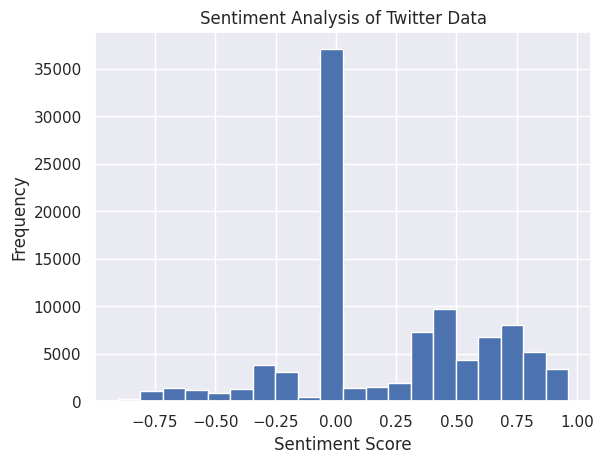

In [ ]:
plt.hist(df['sentiment_score'], bins=20)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis of Twitter Data')
plt.show()

In [ ]:
# Define a function to get the sentiment polarity of a text using VADER
def get_sentiment(text):
    # Use the polarity_scores method of the analyzer to get a dictionary of polarity scores
    sentiment_dict = analyzer.polarity_scores(text)
    # Extract the sentiment polarity score (positive, negative, neutral, or compound)
    sentiment_score = sentiment_dict['compound']
    # Classify the sentiment polarity based on the compound score
    if sentiment_score >= 0.05:
        sentiment = 'positive'
    elif sentiment_score <= -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'
    # Return the sentiment polarity label
    return sentiment

In [ ]:
# Apply the get_sentiment function to each text in a list of texts
texts = ['I love Chatgpt!', 'This hate chatgpt', 'We can learn a lot from chatgpt in education sector']
sentiments = [get_sentiment(text) for text in texts]

In [ ]:
# Print the texts and their corresponding sentiment polarities
for i in range(len(texts)):
    print(f'Text: {texts[i]} \nSentiment: {sentiments[i]}\n')

# Doing Logistic Regression

Since, now we have sentiment scores for each tweets we can use sentiment scores as a feature in a supervised learning model. We can use the sentiment scores as one of the independent variables (features) in our model and the dependent variable (target) would depend on what we want to predict. 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['sentiment_score'], test_size=0.2, random_state=42)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Vectorize the text data
vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = vectorizer.fit_transform([' '.join(text) for text in X_train])
X_test_tfidf = vectorizer.transform([' '.join(text) for text in X_test])


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Convert sentiment scores to binary labels
y_train_binary = np.where(y_train >= 0, 1, 0)
y_test_binary = np.where(y_test >= 0, 1, 0)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Create a logistic regression model and fit it to the data
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train_binary)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LogisticRegression()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Evaluate the model on the test set
y_pred = logreg.predict(X_test_tfidf)
score = accuracy_score(y_test_binary, y_pred)
print("Accuracy:", score)

Accuracy: 0.9999500149955014


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Calculate precision
precision = precision_score(y_test_binary, y_pred)
print("Precision:", precision)

Precision: 0.999941605839416


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Calculate recall
recall = recall_score(y_test_binary, y_pred)
print("Recall:", recall)

Recall: 1.0


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Calculate F1 score
f1 = f1_score(y_test_binary, y_pred)
print("F1 score:", f1)

F1 score: 0.9999708020672136


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_binary, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2882
           1       1.00      1.00      1.00     17124

    accuracy                           1.00     20006
   macro avg       1.00      1.00      1.00     20006
weighted avg       1.00      1.00      1.00     20006



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


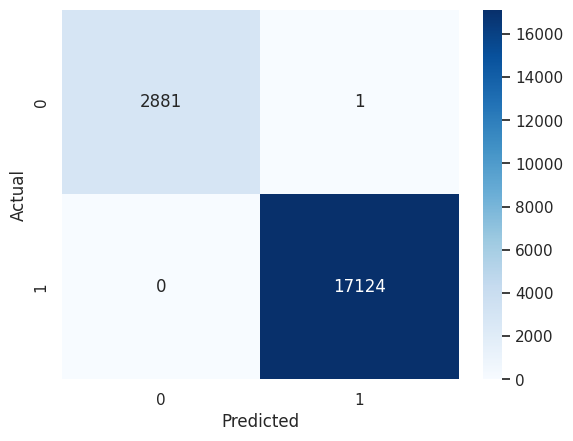

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# SentiWordNet 

SentiWordNet is a lexical resource for sentiment analysis that assigns to each synset (a set of synonyms that share a common meaning) in WordNet three sentiment scores: positivity, negativity, and objectivity. These scores indicate the degree of positivity, negativity, and objectivity associated with the synset. SentiWordNet is built using the WordNet lexical database, which provides a large set of synsets organized into a network of semantic relations.


In [5]:
df = pd.read_csv('/content/chatgpt_tweets-4.csv')

In [8]:
import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd


In [7]:
# Preprocess the text data
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stopwords and punctuations
    tokens = [word for word in tokens if word.isalnum() and word not in stopwords.words('english')]
    return tokens

In [9]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


True

In [10]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

def get_sentiment_score(text):
    try:
        lemmatizer = WordNetLemmatizer()
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(text)
        pos_score = 0
        neg_score = 0
        obj_score = 0
        for token in tokens:
            lemma = lemmatizer.lemmatize(token)
            synsets = list(swn.senti_synsets(lemma))
            if len(synsets) > 0:
                pos_score += synsets[0].pos_score()
                neg_score += synsets[0].neg_score()
                obj_score += synsets[0].obj_score()
        return pos_score, neg_score, obj_score
    except KeyError:
        return None, None, None

In [13]:
import nltk
nltk.download('wordnet')
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import nltk
nltk.download('universal_tagset')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [14]:
from nltk import pos_tag

# Apply the function to each tweet in the dataset
df['pos_score'], df['neg_score'], df['obj_score'] = zip(*df['tweet_text'].apply(get_sentiment_score))

In [15]:
# Calculate the overall sentiment score for each tweet
df['sentiment_score'] = df['pos_score'] - df['neg_score']

In [16]:

# Classify each tweet as positive, negative, or neutral based on the sentiment score
df['sentiment'] = df['sentiment_score'].apply(lambda score: 'positive' if score > 0 else 'negative' if score < 0 else 'neutral')


In [17]:
# Print the resulting dataframe
print(df.head())

                        date  \
0  2022-01-27 14:42:36+00:00   
1  2022-01-08 08:46:33+00:00   
2  2022-01-08 08:37:45+00:00   
3  2021-11-26 16:49:24+00:00   
4  2021-11-26 15:07:12+00:00   

                                          tweet_text  pos_score  neg_score  \
0  RT GPT-3-like models with extended training co...      0.500      0.000   
1  RT Testing GPT-3 on Elementary Physics Unveils...      1.375      1.125   
2  Testing GPT-3 on Elementary Physics Unveils So...      2.125      1.375   
3  Now we know how @BorisJohnson wrote his speech...      0.625      0.000   
4  @sharplm shares how GPT-3 generates believable...      1.875      0.750   

   obj_score  sentiment_score sentiment  
0     20.500            0.500  positive  
1     14.500            0.250  positive  
2     15.500            0.750  positive  
3      6.375            0.625  positive  
4     25.375            1.125  positive  


In [18]:
import plotly.graph_objs as go

# Create a bar chart
data = [go.Bar(x=df['sentiment'].value_counts().index,
               y=df['sentiment'].value_counts().values)]

# Add a title and axis labels
layout = go.Layout(title='Sentiment Analysis Results',
                   xaxis=dict(title='Sentiment'),
                   yaxis=dict(title='Number of Tweets'))

# Create a Figure object
fig = go.Figure(data=data, layout=layout)

# Display the figure
fig.show()
